# 01-mediacloud-prep-urls
**Purpose**:
- get story counts per outlet based on Media Cloud's `media_id`
- get Media Cloud 'stories' which contain URLs per outlet
1) query from API and save CSVs per outlet per year ([code reference - Media Cloud Tutorial notebooks](https://github.com/mediacloud/api-tutorial-notebooks))
2) consolidate as dataframe
3) filter out stories which are not news articles, duplicates, and/or don't have publication time info
4) create a sample stratified by year and outlet
    - check for cases where default 'urlexpander.fetch_url' logic fails -> make alternative URL
5) export full list of URLs with alternative URL
6) create a sample stratified by year and outlet with the alternative URL
    - for testing scrapers in INCA

In [1]:
import csv
import datetime
import os
import urllib.parse

import mediacloud.api
import mediacloud.tags
import pandas as pd
import plotnine as p9
import urlexpander
from dotenv import load_dotenv
from mizani.breaks import date_breaks
from mizani.formatters import date_format

load_dotenv()  # load config from .env file
mc = mediacloud.api.MediaCloud(os.getenv("MC_API_KEY"))
print(f"mediacloud version: {mediacloud.__version__}")

dir_raw = os.path.join("..", "..", "data", "01-raw", "03-mediacloud")
dir_int = os.path.join("..", "..", "data", "02-intermediate", "03-mediacloud")
dir_sample = os.path.join('..', '..', 'data', '02-intermediate', '03-mediacloud-sample')
dir_fig = os.path.join("..", "..", "figures")

from usrightmedia.shared.media_references import get_mediacloud_outlet_ids
from usrightmedia.shared.datetime_utils import END_TIME, START_TIME, EST_to_UTC


mediacloud version: 3.12.3


In [2]:
from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '01-mediacloud-prep-urls', logger_type='main')

- how many stories are expected to be retrieved per outlet?

In [3]:
def get_outlet_story_count(mc, media_id, start_time, end_time):
     """
     Args:
         - mc (obj): a `mediacloud.api.MediaCloud` object already instantiated with the API key
         - media_id (str): Media Cloud's media source ID for the outlet (https://sources.mediacloud.org/#/sources/[media_id])
         - start_time (datetime)
         - end_time (datetime)

     Returns:
         - story_count (int)
     """
     date_range = mc.dates_as_query_clause(start_time, end_time-datetime.timedelta(days=1)) # default is start & end inclusive
     story_count = mc.storyCount(f'media_id:{media_id}', date_range)['count']
     return story_count

In [4]:
df_outlets = get_mediacloud_outlet_ids()

In [5]:
df_outlets['story_count'] = df_outlets['media_id'].map(lambda x: get_outlet_story_count(mc, x, START_TIME, END_TIME))

In [6]:
df_outlets

,outlet,media_id,story_count
0,American Renaissance,26186,9865
1,Breitbart,19334,150281
2,Daily Caller,18775,122278
3,Daily Stormer,113988,15641
4,Fox News,1092,284283
5,Gateway Pundit,25444,39689
6,InfoWars,18515,28597
7,Newsmax,25349,71093
8,One America News,127733,117775
9,Rush Limbaugh,24669,9268


In [7]:
# total stories to collect
df_outlets['story_count'].sum()

973486

## Retrieve Media Cloud stories

In [8]:
def _get_outlet_stories_by_year(mc, media_id, start_year, end_year):
    """Return all the stories for an outlet within the date filter. Page through the results automatically.
    (function is based on tutorial)
    
    Args:
        - mc (obj): a `mediacloud.api.MediaCloud` object already instantiated with the API key
        - media_id (str): Media Cloud's media source ID for the outlet (https://sources.mediacloud.org/#/sources/[media_id])
        - start_year (int)
        - end_year (int)

     Returns:
        - stories (list of Media Cloud story items)
    """
    
    start_time = datetime.datetime(start_year, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)
    end_time = datetime.datetime(end_year, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)

    date_range = mc.dates_as_query_clause(start_time, end_time-datetime.timedelta(days=1)) # default is start & end inclusive

    last_id = 0
    more_stories = True
    stories = []
    while more_stories:
        page = mc.storyList(solr_query = f'media_id:{media_id}',
                            solr_filter = date_range,
                            last_processed_stories_id=last_id,
                            rows=500, # fetch size
                            sort='processed_stories_id')
        LOGGER.info(f"{media_id}, {start_year}: got one page with {len(page)} stories")
        
        if len(page) == 0:
            more_stories = False

        else:
            stories += page
            last_id = page[-1]['processed_stories_id']

    return stories

In [9]:
def _outlet_stories_to_csv(stories, media_id, year):
    """ Write stories to CSV
    (function is based on tutorial)
    
    Args:
        - stories (obj): Media Cloud story items
        - media_id (str): Media Cloud's media source ID for the outlet (https://sources.mediacloud.org/#/sources/[media_id])
        - year (int)
    
    Returns:
        None; outputs CSV of stories
    """
    for s in stories:
        theme_tag_names = ','.join([t['tag'] for t in s['story_tags'] if t['tag_sets_id'] == mediacloud.tags.TAG_SET_NYT_THEMES])
        s['themes'] = theme_tag_names

    # now write the CSV
    fieldnames = ['stories_id', 'publish_date', 'title', 'url', 'language', 'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url']
    with open(os.path.join(dir_raw, f'stories_{media_id}_{year}.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction='ignore')
        writer.writeheader()
        for s in stories:
            writer.writerow(s)

In [10]:
def _get_outlet_stories_in_year_range(mc, media_id, start_year, end_year):
    """ request an outlet's stories for a year range
    Args:
        - mc (obj): a `mediacloud.api.MediaCloud` object already instantiated with the API key
        - media_id (str): Media Cloud's media source ID for the outlet (https://sources.mediacloud.org/#/sources/[media_id])

    Returns:
        None
    """
    
    for year in range(start_year, end_year): # 2016 to 2021
        LOGGER.info(f"collecting stories for media_id {media_id} in {year}")
        stories = _get_outlet_stories_by_year(mc, media_id, year, year + 1)
        _outlet_stories_to_csv(stories, media_id, year)

In [11]:
def _stories_csv_to_df(media_id):
    """combine annual CSVs of stories for a given outlet

    Args:
        media_id (str)

    Returns:
        writes a dataframe of stories from 2016 - 2020
    
    """

    df16 = pd.read_csv(os.path.join(dir_raw, f'stories_{media_id}_2016.csv'))
    df17 = pd.read_csv(os.path.join(dir_raw, f'stories_{media_id}_2017.csv'))
    df18 = pd.read_csv(os.path.join(dir_raw, f'stories_{media_id}_2018.csv'))
    df19 = pd.read_csv(os.path.join(dir_raw, f'stories_{media_id}_2019.csv'))
    df20 = pd.read_csv(os.path.join(dir_raw, f'stories_{media_id}_2020.csv'))

    df = pd.concat([df16, df17, df18, df19, df20]).reset_index(drop=True)
    df.to_pickle(os.path.join(dir_int, f'stories_{media_id}.pkl'))

In [12]:
def collect_stories(media_id):
    """collect stories from Media Cloud based on a media_id

    Args:
        media_id (str): Media Cloud's media source ID for the outlet (https://sources.mediacloud.org/#/sources/[media_id])
        
    Returns:
        writes stories per outlet to CSV

    """
    _get_outlet_stories_in_year_range(mc, media_id, 2016, 2021)
    _stories_csv_to_df(media_id)

In [13]:
df_outlets.sort_values('story_count')

,outlet,media_id,story_count
9,Rush Limbaugh,24669,9268
0,American Renaissance,26186,9865
3,Daily Stormer,113988,15641
11,VDARE,24641,20525
6,InfoWars,18515,28597
10,Sean Hannity,28136,29712
5,Gateway Pundit,25444,39689
7,Newsmax,25349,71093
12,Washington Examiner,6443,74479
8,One America News,127733,117775


- collect per outlet (easier to check if running against API limit)

In [14]:
# collect_stories('24669')
# collect_stories('26186')
# collect_stories('113988')
# collect_stories('24641')
# collect_stories('18515')
# collect_stories('28136')
# collect_stories('25444')
# collect_stories('25349')
# collect_stories('6443')
# collect_stories('127733')
# collect_stories('18775')
# collect_stories('19334')
# collect_stories('1092')

- combine dataframes of outlets' stories
- convert EST from Media Cloud to UTC

In [15]:
df_stories = []
for media_id in df_outlets['media_id']:
    dfs = pd.read_pickle(os.path.join(dir_int, f'stories_{media_id}.pkl'))
    df_stories.append(dfs)

df_stories = pd.concat(df_stories).reset_index(drop=True)

# fix data types
df_stories['stories_id'] = df_stories['stories_id'].astype('str')
df_stories['publish_date'] = pd.to_datetime(df_stories['publish_date'])
df_stories['publish_date'] = df_stories['publish_date'].map(lambda t: EST_to_UTC(t)) # timezone-aware
df_stories['media_id'] = df_stories['media_id'].astype('str')

# add date buckets
df_stories['publish_week'] = df_stories['publish_date'].dt.to_period('W').dt.to_timestamp()
df_stories['publish_month'] = df_stories['publish_date'].dt.to_period('M').dt.to_timestamp()
df_stories['publish_year'] = df_stories['publish_date'].dt.to_period('Y').dt.to_timestamp()

# add outlet names
df_stories = df_stories.merge(df_outlets[['media_id', 'outlet']],on='media_id',how='left')

/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.


- show example

In [16]:
dfs.loc[dfs['stories_id']==411034811]

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
4,411034811,2016-01-01 09:49:12,"Tel Aviv shooting leaves 2 dead, at least 5 in...",http://www.washingtonexaminer.com/tel-aviv-sho...,en,False,NaN,6443,Washington Examiner,http://www.washingtonexaminer.com/politics


In [17]:
df_stories.loc[df_stories['stories_id']=='411034811']

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,publish_week,publish_month,publish_year,outlet
893452,411034811,2016-01-01 14:49:12+00:00,"Tel Aviv shooting leaves 2 dead, at least 5 in...",http://www.washingtonexaminer.com/tel-aviv-sho...,en,False,NaN,6443,Washington Examiner,http://www.washingtonexaminer.com/politics,2015-12-28,2016-01-01,2016-01-01,Washington Examiner


- check: date range of retrieved stories (`dfr_dates`)
- check: URLs which are missing publication time information (`dfr_no_date`)
- check: how many stories expected vs. how many retrieved (`df_outlets`)

In [18]:
dfr_dates = df_stories.groupby('media_id').agg({'publish_date': ['min', 'max']}).reset_index()
dfr_dates.columns = dfr_dates.columns.to_flat_index()
dfr_dates = dfr_dates.rename(columns={dfr_dates.columns[0]: "media_id",
                                      dfr_dates.columns[1]: "min_retrieved_date",
                                      dfr_dates.columns[2]: "max_retrieved_date"})
df_outlets = df_outlets.merge(dfr_dates, on='media_id')

In [19]:
# faster to groupby 'publish_year' than 'publish_date'
with pd.option_context('max_rows', None):
    dfr_no_date = (df_stories.groupby(['media_id','outlet','publish_year'], dropna=False)
                               .size()
                               .to_frame('no_date_count')
                               .reset_index()
                               .pipe(lambda d: d[d['publish_year'].isna()])
                               .reset_index(drop=True))

    display(dfr_no_date)

,media_id,outlet,publish_year,no_date_count
0,1092,Fox News,NaT,1440
1,113988,Daily Stormer,NaT,1
2,127733,One America News,NaT,409
3,18515,InfoWars,NaT,146
4,18775,Daily Caller,NaT,8
5,19334,Breitbart,NaT,29
6,24641,VDARE,NaT,229
7,24669,Rush Limbaugh,NaT,1
8,25349,Newsmax,NaT,62
9,25444,Gateway Pundit,NaT,2


In [20]:
df_outlets = df_outlets.merge(dfr_no_date[['media_id', 'no_date_count']], on='media_id')

In [21]:
dfr_count = pd.DataFrame(df_stories.value_counts('media_id')).reset_index().rename(columns={0:'retrieved_count'})
dfr_count['media_id'] = dfr_count['media_id'].astype('str')
df_outlets = df_outlets.merge(dfr_count, on='media_id')

In [22]:
df_outlets['exp_ret_diff_count'] = df_outlets['retrieved_count'] - df_outlets['story_count']
df_outlets['retrieved_pct'] = round(df_outlets['retrieved_count']/df_outlets['story_count']*100,2)
df_outlets['no_date_pct'] = round(df_outlets['no_date_count']/df_outlets['retrieved_count']*100,2)

In [23]:
df_outlets = df_outlets[['outlet', 'media_id',
                         'story_count', 'retrieved_count', 'no_date_count', 'exp_ret_diff_count',
                         'retrieved_pct', 'no_date_pct','min_retrieved_date', 'max_retrieved_date']]
df_outlets

,outlet,media_id,story_count,retrieved_count,no_date_count,exp_ret_diff_count,retrieved_pct,no_date_pct,min_retrieved_date,max_retrieved_date
0,American Renaissance,26186,9865,9842,4,-23,99.77,0.04,2016-01-01 22:05:54+00:00,2020-12-31 22:23:15+00:00
1,Breitbart,19334,150281,149991,29,-290,99.81,0.02,2016-01-01 06:06:41+00:00,2021-01-01 04:36:21+00:00
2,Daily Caller,18775,122278,121923,8,-355,99.71,0.01,2016-01-01 05:05:19+00:00,2021-01-01 03:34:48+00:00
3,Daily Stormer,113988,15641,15827,1,186,101.19,0.01,2016-01-02 16:08:38+00:00,2021-01-01 03:00:54+00:00
4,Fox News,1092,284283,279879,1440,-4404,98.45,0.51,2016-01-01 05:00:00+00:00,2021-01-01 04:46:27+00:00
5,Gateway Pundit,25444,39689,39413,2,-276,99.30,0.01,2016-01-01 14:29:32+00:00,2021-01-01 04:30:09+00:00
6,InfoWars,18515,28597,28605,146,8,100.03,0.51,2016-01-01 17:22:02+00:00,2020-12-15 05:00:00+00:00
7,Newsmax,25349,71093,71225,62,132,100.19,0.09,2016-01-01 11:21:22+00:00,2021-01-01 02:37:43+00:00
8,One America News,127733,117775,117700,409,-75,99.94,0.35,2016-02-18 18:40:17+00:00,2021-01-01 02:34:08+00:00
9,Rush Limbaugh,24669,9268,9397,1,129,101.39,0.01,2016-01-04 14:54:21+00:00,2020-12-31 16:25:11+00:00


In [24]:
print(f"{round(df_outlets['retrieved_count'].sum()/df_outlets['story_count'].sum()*100, 2)}% of expected stories retrieved.")
print(f"VDARE: {round(100-df_outlets['retrieved_pct'].min(),2)}% difference at outlet-level compared to `mc.storyCount`.")
print(f"Washington Examiner: {round(df_outlets['no_date_pct'].max(),2)}% of retrieved URLs missing publication time information.")

99.5% of expected stories retrieved.
VDARE: 3.18% difference at outlet-level compared to `mc.storyCount`.
Washington Examiner: 4.52% of retrieved URLs missing publication time information.


In [25]:
# summary of Media Cloud API retrieval
# df_outlets.to_latex(os.path.join(dir_fig, 'c0301_mediacloud_api.tex'), index=False)

## Filter Media Cloud stories

- extract the domain and network location from the URLs

In [26]:
df_stories['url_domain'] = df_stories['url'].map(lambda x: urlexpander.url_utils.get_domain(x)) # domain as recorded in public suffix list (https://github.com/john-kurkowski/tldextract)
df_stories['url_netloc'] = df_stories['url'].map(lambda x: urlexpander.url_utils.get_netloc(x)) # includes custom domains

In [27]:
# by domain
df_stories.pivot_table(index='url_domain',columns='outlet', aggfunc='size')

outlet,American Renaissance,Breitbart,Daily Caller,Daily Stormer,Fox News,Gateway Pundit,InfoWars,Newsmax,One America News,Rush Limbaugh,Sean Hannity,VDARE,Washington Examiner
url_domain,,,,,,,,,,,,,
amren.com,9842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
breitbart.com,NaN,45690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
checkyourfact.com,NaN,NaN,1620.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dailycaller.com,NaN,NaN,115140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dailycallerdev.com,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dailystormer.com,NaN,NaN,NaN,7319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dailystormer.name,NaN,NaN,NaN,4473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dailystormer.su,NaN,NaN,NaN,4035.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dailyvaper.com,NaN,NaN,208.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# by netloc
df_stories.pivot_table(index='url_netloc',columns='outlet', aggfunc='size')

outlet,American Renaissance,Breitbart,Daily Caller,Daily Stormer,Fox News,Gateway Pundit,InfoWars,Newsmax,One America News,Rush Limbaugh,Sean Hannity,VDARE,Washington Examiner
url_netloc,,,,,,,,,,,,,
2020.washingtonexaminer.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
WWW.FOXNEWS.COM,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a57.foxnews.com,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amp.dailycaller.com,NaN,NaN,347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
archives.infowars.com,NaN,NaN,NaN,NaN,NaN,NaN,189.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
www.rushlimbaugh.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7291.0,NaN,NaN,NaN
www.thegatewaypundit.com,NaN,NaN,NaN,NaN,NaN,39237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
www.vdare.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11016.0,NaN


In [29]:
# exclude a URL if its netloc contains any of these substrings
netlocs_to_exclude = [
    netloc
    for netloc in list(df_stories["url_netloc"].unique())
    if any(
        x in netloc
        for x in [
            "video",
            "tv",
            "shop",
            "store",
            "deals",
            "forums",
            "media.breitbart.com",
            "media2.foxnews.com",
            "dailycallerdev.com",
            "a57.foxnews.com",
        ]
    )
]
netlocs_to_exclude


['media.breitbart.com',
 'video.breitbart.com',
 'deals.breitbart.com',
 'video.dailycaller.com',
 'dailycallerdev.com',
 'shop.dailycaller.com',
 'video.foxnews.com',
 'video.foxbusiness.com',
 'a57.foxnews.com',
 'video.latino.foxnews.com',
 'video.insider.foxnews.com',
 'media2.foxnews.com',
 'store.infowars.com',
 'tv.infowars.com',
 'video.infowars.com',
 'shop.newsmax.com',
 'forums.hannity.com']

In [30]:
# filter conditions
df_stories['exclude_netloc'] = df_stories['url_netloc'].map(lambda netloc: True if netloc in netlocs_to_exclude else False)
df_stories['exclude_dupe'] = df_stories.duplicated(subset=['stories_id', 'publish_date', 'title', 'url']) # first instance shows False, later instances show True
df_stories['exclude_HotForumTopics'] = df_stories['url'].map(lambda url: True if "TheSeanHannityShow-HotForumTopics" in url else False)
df_stories['exclude_no_date'] = df_stories['publish_date'].isna() # NaT

In [31]:
df_stories_filtered = df_stories.loc[(~df_stories['exclude_netloc']) & (~df_stories['exclude_dupe']) & (~df_stories['exclude_HotForumTopics']) & (~df_stories['exclude_no_date'])]
df_stories_filtered = df_stories_filtered.sort_values('publish_date').reset_index(drop=True) # sort by publication time
df_stories_filtered.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,publish_week,publish_month,publish_year,outlet,url_domain,url_netloc,exclude_netloc,exclude_dupe,exclude_HotForumTopics,exclude_no_date
0,948857607,2016-01-01 05:00:00+00:00,Obama to meet Monday with AG Lynch about 'opti...,http://www.foxnews.com/politics/2016/01/01/oba...,en,False,NaN,1092,Fox News,http://www.foxnews.com/,2015-12-28,2016-01-01,2016-01-01,Fox News,foxnews.com,www.foxnews.com,False,False,False,False
1,591138753,2016-01-01 05:00:12+00:00,Email hints at Hillary Clinton's secret role i...,http://www.washingtonexaminer.com/email-hints-...,en,False,NaN,6443,Washington Examiner,http://www.washingtonexaminer.com/politics,2015-12-28,2016-01-01,2016-01-01,Washington Examiner,washingtonexaminer.com,www.washingtonexaminer.com,False,False,False,False
2,410957319,2016-01-01 05:01:00+00:00,Munich rail stations reopen after terror alert...,http://feeds.foxnews.com/~r/foxnews/world/~3/N...,en,True,NaN,1092,Fox News,http://www.foxnews.com/,2015-12-28,2016-01-01,2016-01-01,Fox News,foxnews.com,feeds.foxnews.com,False,False,False,False
3,713238906,2016-01-01 05:05:19+00:00,Here’s What A Black Lives Matter New Years Eve...,http://dailycaller.com/2016/01/01/pictures-bla...,en,False,NaN,18775,Daily Caller,http://dailycaller.com,2015-12-28,2016-01-01,2016-01-01,Daily Caller,dailycaller.com,dailycaller.com,False,False,False,False
4,1567916749,2016-01-01 06:06:41+00:00,Sonnie Johnson: From ‘Trans-Racial’ to Cultura...,https://www.breitbart.com/politics/2015/12/31/...,en,False,NaN,19334,Breitbart,http://www.breitbart.com,2015-12-28,2016-01-01,2016-01-01,Breitbart,breitbart.com,www.breitbart.com,False,False,False,False


In [55]:
print(f"Excluded {len(df_stories)-len(df_stories_filtered)} stories (i.e., Media Cloud URLs) from further processing (note: the conditions for dropping are not exclusive)")
print(f"- {len(df_stories.loc[df_stories['exclude_netloc']])} stories can be excluded due to non-relevant netloc.") # includes a portion of Hannity forums
print(f"- {len(df_stories.loc[df_stories['exclude_dupe']])} stories can be excluded due to being a duplicate story.")
print(f"- {len(df_stories.loc[df_stories['exclude_HotForumTopics']])} stories can be excluded due to non-relevant forum threads.") # Hannity forums
print(f"- {len(df_stories.loc[df_stories['exclude_no_date']])} stories can be excluded due to lack of publication time info.")
print(f"Keeping {len(df_stories_filtered)} stories for further processing.")

Excluded 44471 stories (i.e., Media Cloud URLs) from further processing (note: the conditions for dropping are not exclusive)
- 30375 stories can be excluded due to non-relevant netloc.
- 157 stories can be excluded due to being a duplicate story.
- 8600 stories can be excluded due to non-relevant forum threads.
- 5730 stories can be excluded due to lack of publication time info.
Keeping 924115 stories for further processing.


In [33]:
df_stories_filtered.columns

Index(['stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'publish_week', 'publish_month', 'publish_year', 'outlet', 'url_domain',
       'url_netloc', 'exclude_netloc', 'exclude_dupe',
       'exclude_HotForumTopics', 'exclude_no_date'],
      dtype='object')

In [34]:
df_mc_stories_outlet_smry = (
    df_stories_filtered.groupby(
        ["outlet", "media_id", "media_name", "url_domain", "url_netloc"], dropna=False
    )
    .size()
    .to_frame("filtered_url_count")
    .sort_values(by=["outlet", "filtered_url_count"], ascending=[True, False])
    .reset_index(drop=False)
)
df_mc_stories_outlet_smry


,outlet,media_id,media_name,url_domain,url_netloc,filtered_url_count
0,American Renaissance,26186,amren.com,amren.com,www.amren.com,9837
1,American Renaissance,26186,amren.com,amren.com,w.amren.com,1
2,Breitbart,19334,Breitbart,google.com,feedproxy.google.com,104291
3,Breitbart,19334,Breitbart,breitbart.com,www.breitbart.com,44928
4,Breitbart,19334,Breitbart,breitbart.com,www.breitbart.com:80,41
...,...,...,...,...,...,...
57,Washington Examiner,6443,Washington Examiner,washingtonexaminer.com,www.washingtonexaminer.com,71544
58,Washington Examiner,6443,Washington Examiner,washingtonexaminer.com,www.washingtonexaminer.com:80,113
59,Washington Examiner,6443,Washington Examiner,washingtonexaminer.com,m.washingtonexaminer.com,48
60,Washington Examiner,6443,Washington Examiner,washingtonexaminer.com,2020.washingtonexaminer.com,10


In [35]:
# export the summary of outlet to url_domain/url_netloc to help with filtering URLs before URL matching task
# RSS feed URLs need to be expanded (e.g., feedproxy.google.com)
df_mc_stories_outlet_smry.to_pickle(os.path.join(dir_int, "df_mc_stories_outlet_smry.pkl"))

In [36]:
# quick search for urls which include a substring
df_stories.loc[df_stories['url'].str.contains('feeds.foxnews.com')]['url'].iloc[30]

'http://feeds.foxnews.com/~r/foxnews/world/~3/hn2EWXfKuG4/2-tourists-from-china-and-australia-die-in-swimming-accidents-at-thai-island.html'

- summarize and visualize article URL counts by outlet over time

In [37]:
# count of filtered stories per outlet by year
df_stories_filtered.pivot_table(index='outlet',columns='publish_year', aggfunc='size')

publish_year,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01
outlet,,,,,,
American Renaissance,1693.0,1795.0,1749.0,1825.0,2776.0,NaN
Breitbart,30083.0,31771.0,24591.0,25908.0,36888.0,20.0
Daily Caller,19359.0,26241.0,25856.0,21268.0,29098.0,9.0
Daily Stormer,4361.0,2953.0,1107.0,3025.0,4377.0,3.0
Fox News,47737.0,48922.0,45156.0,47633.0,75173.0,27.0
Gateway Pundit,4810.0,8095.0,5988.0,7195.0,13313.0,7.0
InfoWars,2094.0,2392.0,8071.0,7537.0,8359.0,NaN
Newsmax,10568.0,11093.0,7706.0,9566.0,32213.0,12.0
One America News,7568.0,21018.0,22732.0,23282.0,42687.0,3.0


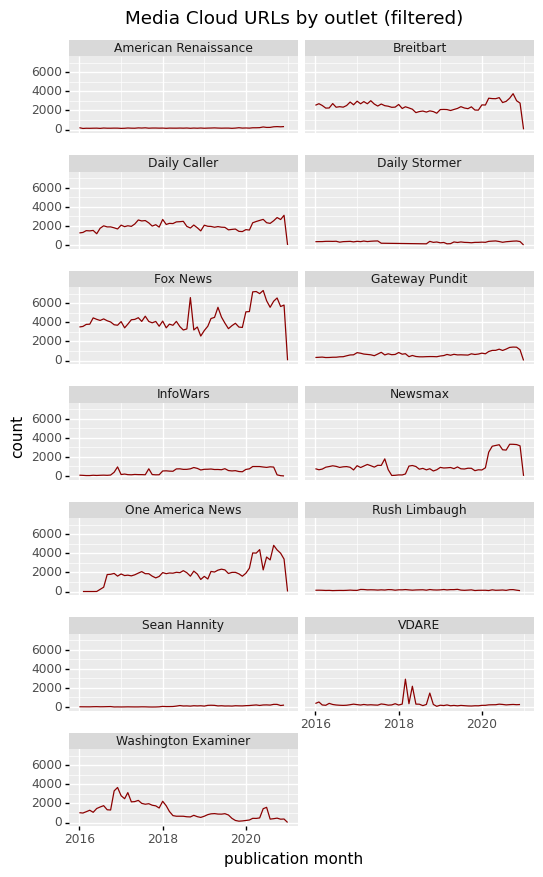

<ggplot: (8753239651030)>

In [38]:
plt = (p9.ggplot(df_stories_filtered, p9.aes(x='publish_month'))
+ p9.geom_line(stat='count', color='darkred')
+ p9.scale_x_datetime(name='publication month',
                      breaks=date_breaks('2 years'),
                      labels=date_format('%Y'))
+ p9.facet_wrap('outlet',
                ncol=2)
+ p9.theme(figure_size=(6,10),
           legend_position='none',
           subplots_adjust={'hspace':0.5})
+ p9.labs(title = f'Media Cloud URLs by outlet (filtered)'))

plt

In [39]:
# count of retrieved URLs per outlet by month from 2016 - 2020
# plt.save(os.path.join(dir_fig, 'c0301__mediacloud_api_timeline.svg'))

## Refer to stories as URLs moving forward

In [40]:
df_urls = df_stories_filtered.rename(columns={'stories_id': 'url_id'})
df_urls.head()

,url_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,publish_week,publish_month,publish_year,outlet,url_domain,url_netloc,exclude_netloc,exclude_dupe,exclude_HotForumTopics,exclude_no_date
0,948857607,2016-01-01 05:00:00+00:00,Obama to meet Monday with AG Lynch about 'opti...,http://www.foxnews.com/politics/2016/01/01/oba...,en,False,NaN,1092,Fox News,http://www.foxnews.com/,2015-12-28,2016-01-01,2016-01-01,Fox News,foxnews.com,www.foxnews.com,False,False,False,False
1,591138753,2016-01-01 05:00:12+00:00,Email hints at Hillary Clinton's secret role i...,http://www.washingtonexaminer.com/email-hints-...,en,False,NaN,6443,Washington Examiner,http://www.washingtonexaminer.com/politics,2015-12-28,2016-01-01,2016-01-01,Washington Examiner,washingtonexaminer.com,www.washingtonexaminer.com,False,False,False,False
2,410957319,2016-01-01 05:01:00+00:00,Munich rail stations reopen after terror alert...,http://feeds.foxnews.com/~r/foxnews/world/~3/N...,en,True,NaN,1092,Fox News,http://www.foxnews.com/,2015-12-28,2016-01-01,2016-01-01,Fox News,foxnews.com,feeds.foxnews.com,False,False,False,False
3,713238906,2016-01-01 05:05:19+00:00,Here’s What A Black Lives Matter New Years Eve...,http://dailycaller.com/2016/01/01/pictures-bla...,en,False,NaN,18775,Daily Caller,http://dailycaller.com,2015-12-28,2016-01-01,2016-01-01,Daily Caller,dailycaller.com,dailycaller.com,False,False,False,False
4,1567916749,2016-01-01 06:06:41+00:00,Sonnie Johnson: From ‘Trans-Racial’ to Cultura...,https://www.breitbart.com/politics/2015/12/31/...,en,False,NaN,19334,Breitbart,http://www.breitbart.com,2015-12-28,2016-01-01,2016-01-01,Breitbart,breitbart.com,www.breitbart.com,False,False,False,False


- convert NaNs in 'themes' column to empty strings

In [41]:
df_urls['themes'] = df_urls['themes'].map(lambda x: x if isinstance(x,str) else "")

## Create a sample of URLs

In [42]:
def sample_outlet(df_url, outlet, n_per_year, start_year, end_year):
    """collect a sample for a specific outlet"""
    sampled = []
    for year in pd.date_range(start_year, end_year, freq='AS'):
        # make timestamp naive so it matches filter condition
        year = year.tz_convert(None)
        df_year = (df_url.loc[(df_url['outlet']==outlet)&
                             (df_url['publish_year']==year)]
                        .reset_index(drop=True))
        
        # get the specified number of URLs
        if len(df_year) >= n_per_year:
            s = df_year.sample(n_per_year,random_state=42)
        else:
            s = df_year
        sampled.append(s)
        
    df_sampled =  pd.concat(sampled).reset_index(drop=True)
    
    return df_sampled

In [43]:
def sample_all_outlets(df_urls, n_per_year, start_year, end_year):
    """collect a sample for all outlets"""
    outlets = list(df_urls['outlet'].unique())
    df_list = [sample_outlet(df_urls, outlet, n_per_year, start_year, end_year) for outlet in outlets]
    df_sample = pd.concat(df_list).sort_values(by=['outlet','publish_date']).reset_index(drop=True)
    return df_sample

In [44]:
df_urls_sampled = sample_all_outlets(df_urls,
                            n_per_year=5,
                            start_year=START_TIME,
                            end_year=END_TIME)
len(df_urls_sampled)

361

In [45]:
df_urls_sampled = df_urls_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_urls_sampled.head()

,url_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,publish_week,publish_month,publish_year,outlet,url_domain,url_netloc,exclude_netloc,exclude_dupe,exclude_HotForumTopics,exclude_no_date
0,1565840471,2020-04-01 17:00:59+00:00,Joe Biden Appears To Be Reading From Note Card...,https://www.thegatewaypundit.com/2020/04/joe-b...,en,False,,25444,GatewayPundit,http://www.thegatewaypundit.com,2020-03-30,2020-04-01,2020-01-01,Gateway Pundit,thegatewaypundit.com,www.thegatewaypundit.com,False,False,False,False
1,693039388,2017-09-20 03:43:35+00:00,Paul Manafort: Justice Department Should ‘Imme...,http://feedproxy.google.com/~r/breitbart/~3/k0...,en,False,,19334,Breitbart,http://www.breitbart.com,2017-09-18,2017-09-01,2017-01-01,Breitbart,google.com,feedproxy.google.com,False,False,False,False
2,1215520724,2019-03-05 19:49:51+00:00,Zimbabwe Needs R3.2 Billion in Aid Donations t...,https://www.amren.com/news/2019/03/zimbabwe-ne...,en,False,,26186,amren.com,http://www.amren.com,2019-03-04,2019-03-01,2019-01-01,American Renaissance,amren.com,www.amren.com,False,False,False,False
3,1357782493,2019-08-06 01:43:36+00:00,"Verified Twitter Users Wrongfully Blame ""White...",https://vdare.com/posts/verified-twitter-users...,en,False,,24641,VDARE,http://www.vdare.com,2019-08-05,2019-08-01,2019-01-01,VDARE,vdare.com,vdare.com,False,False,False,False
4,473766404,2016-06-03 15:12:44+00:00,As Many As 100 ISIS Terrorists In Belgium May ...,http://dailycaller.com/2016/06/03/as-many-as-1...,en,False,"politics and government,terrorism,internationa...",18775,Daily Caller,http://dailycaller.com,2016-05-30,2016-06-01,2016-01-01,Daily Caller,dailycaller.com,dailycaller.com,False,False,False,False


In [46]:
# sampled URLs by outlet and year
sample_smry = (df_urls_sampled.groupby(['outlet', 'publish_year'])['url']
                .apply(list)
                .to_frame('urls')
                .reset_index())
sample_smry['count'] = sample_smry['urls'].str.len()
with pd.option_context('max_rows', None, 'max_colwidth', None):
    display(sample_smry.head())

,outlet,publish_year,urls,count
0,American Renaissance,2016-01-01,"[http://www.amren.com/news/2016/12/austrias-far-right-sees-prize-within-reach-presidency/, http://www.amren.com/news/2016/10/clintons-florida-secret-weapon-new-puerto-rican-arrivals/, https://www.amren.com/news/2016/12/americas-schools-must-zero-tolerance-racist-teachers-board-members/, http://www.amren.com/news/2016/09/paris-is-a-post-apocalyptic-hellhole-of-public-urination-and-litter-hurrah-for-the-incivility-brigade/, https://www.amren.com/news/2016/09/what-if-muslim-immigrants-dont-want-to-be-like-us/]",5
1,American Renaissance,2017-01-01,"[https://www.amren.com/commentary/2017/11/worlds-most-important-graph-demographic-projections/, https://www.amren.com/news/2017/02/call-centers-provide-jobs-deportees/, https://www.amren.com/news/2017/09/climate-change-mass-immigration-green-identity-politics/, https://www.amren.com/news/2017/04/video-pepsi-pulls-kendall-jenner-ad-ridiculed-co-opting-protest-movements/, https://www.amren.com/news/2017/09/baltimore-keep-clean-defaced-francis-scott-key-statue/]",5
2,American Renaissance,2018-01-01,"[https://www.amren.com/news/2018/01/doctors-deal-racist-patients/, https://www.amren.com/news/2018/03/hatred-against-germans-is-increasing-in-berlin-says-citys-interior-minister/, https://www.amren.com/news/2018/05/record-6200-foreign-criminals-are-living-in-britain-instead-of-being-deported/, https://www.amren.com/news/2018/10/the-secrets-of-getting-into-harvard-were-once-closely-guarded-thats-about-to-change/, https://www.amren.com/news/2018/06/cnn-analyst-defends-maxine-waters-suggests-democrat-leaders-are-racist/]",5
3,American Renaissance,2019-01-01,"[https://www.amren.com/news/2019/03/zimbabwe-needs-r3-2-billion-in-aid-donations-to-feed-its-people-un/, https://www.amren.com/news/2019/04/alarmingly-low-fas-sciences-struggles-to-increase-proportion-of-underrepresented-minority-faculty/, https://www.amren.com/news/2019/05/democrats-dont-want-to-nominate-a-candidate-who-looks-like-bernie-or-joe/, https://www.amren.com/news/2019/12/democrats-dont-want-diversity/, https://www.amren.com/news/2019/07/san-francisco-school-board-votes-to-destroy-controversial-washington-high-mural/]",5
4,American Renaissance,2020-01-01,"[https://www.amren.com/news/2020/06/clemson-coach-danny-pearman-apologizes-for-saying-n-word-in-2017-practice-incident/, https://www.amren.com/news/2020/10/marine-le-pen-rejects-new-eu-migrant-pact-as-suicide-of-europe/, https://www.amren.com/blog/2020/09/andrew-sullivan-new-york-times-bell-curve/, https://www.amren.com/commentary/2020/06/law-and-order-riots-police-pat-buchanan/, https://www.amren.com/news/2020/06/in-birmingham-fires-windows-shattered-at-banks-businesses-as-reporters-attacked/]",5


## Export the sampled version of Media Cloud URLs

- trim down the columns and re-order them before export

In [47]:
columns_to_export = [
    "url_id",
    "outlet",
    "publish_date",
    "title",
    "url",
    "ap_syndicated",
    "themes",
]

In [48]:
# export sample of URLs
# Oct 10, 2021: overwrote original sample by filtering out HotForumTopics
df_urls_sampled = df_urls_sampled[columns_to_export]
df_urls_sampled.to_pickle(os.path.join(dir_sample, 'mediacloud_urls_sampled.pkl'))
df_urls_sampled.to_csv(os.path.join(dir_sample, 'mediacloud_urls_sampled.csv'), index=False)

## Based on the sample, add a column for alternative URL versions

- notes from spot-check:
    - American Renaissance
    - Breitbart
    - Daily Caller
    - Daily Stormer has used multiple domain names: `https://www.dailystormer.com`, `https://www.dailystormer.name`, `https://www.dailystormer.su`
        - if `.com` fails to fetch, try `.su`
        - if `.name` fails to fetch, try `.su`
    - Fox News
    - Gateway Pundit
    - InfoWars has a subdomain for archived articles
        if `https://www.infowars.com` fails to fetch, try `https://archives.infowars.com/`
    - OANN: a spot-check of URLs shows that many older pages are no longer directly available. Wayback Machine has at archived versions available.
    - Newsmax
    - Rush Limbaugh: the webpages are available but the default article extract (newsplease) fails to scrape the content.
    - Sean Hannity: filtered out `forums.hannity.com` and `HotForumTopics`
    - Washington Examiner: when scraping the sampled articles with urlexpander, 13/30 articles are not available on washingtonexaminer.com. They redirect to washingtonexaminer.com/tag/... and return '200'

- Fetching logic:
    - for Daily Stormer and InfoWars: try an alternative URL if the original URL fails to fetch with `fetch_url()` (i.e., combines `try_urlexpander()` with `try_waybackpy()` as a fallback option).
    - for Washington Examiner: the sample shows that `try_urlexpander()` is successful at fetching 100% of the sample and does not indicate an error in `fetch_error`.
        - However, although they all return the `200` status code, 13/30 actually return a `resolved_url` containing `https://www.washingtonexaminer.com/tag/...`.
        - Since `try_waybackpy()` isn't called due to the `200`, the fetching logic should manually call the fallback function to the archive.

In [49]:
def get_alt_url(url):
    '''
    Args:
        url (str)
    Returns:
        new_url (str)
    '''
    
    url = url.lower() # https://stackoverflow.com/a/17113291; domain names are case-insensitive
    domain = urlexpander.url_utils.get_domain(url)

    new_url = ""
    
    if domain == 'dailystormer.name':
        new_url = url.replace('dailystormer.name','dailystormer.su')
    elif domain == 'dailystormer.com':
        new_url = url.replace('dailystormer.com','dailystormer.su')
    elif domain=='infowars.com':
        new_url = url.replace('infowars.com', 'archives.infowars.com')
        # remove www.: the regular site accepts www. but the archives site does not
        new_url = new_url.replace('www.', '')
        
    return new_url

In [50]:
df_urls["alt_url"] = df_urls.apply(lambda x: get_alt_url(x["url"]), axis=1)

## Export the full version of Media Cloud URLs

In [51]:
df_urls_trimmed = df_urls[["url_id", "outlet", "publish_date", "title", "url", "alt_url", "ap_syndicated", "themes"]]
df_urls_trimmed.to_pickle(os.path.join(dir_int, 'mediacloud_urls.pkl'))
df_urls_trimmed.to_csv(os.path.join(dir_int, 'mediacloud_urls.csv'), index=False)

## Create a sample of URLs with the alternative URL field
- For testing scrapers in INCA (see `04-inca-prep`)

In [52]:
df_urls_sampled = sample_all_outlets(df_urls,
                            n_per_year=10,
                            start_year=START_TIME,
                            end_year=END_TIME)
len(df_urls_sampled)

708

In [53]:
df_urls_sampled = df_urls_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_urls_sampled.head()

,url_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,...,publish_month,publish_year,outlet,url_domain,url_netloc,exclude_netloc,exclude_dupe,exclude_HotForumTopics,exclude_no_date,alt_url
0,572539767,2017-01-26 17:26:51+00:00,Americans Split On If Police Should Be Able To...,http://dailycaller.com/2017/01/26/americans-sp...,en,False,"computers and the internet,terrorism,crime and...",18775,Daily Caller,http://dailycaller.com,...,2017-01-01,2017-01-01,Daily Caller,dailycaller.com,dailycaller.com,False,False,False,False,
1,1063918366,2018-11-08 01:07:07+00:00,Alaska fishermen sentenced for killing endange...,http://feeds.foxnews.com/~r/foxnews/national/~...,en,False,"no index terms from nytimes,crime and criminal...",1092,Fox News,http://www.foxnews.com/,...,2018-11-01,2018-01-01,Fox News,foxnews.com,feeds.foxnews.com,False,False,False,False,
2,1577862533,2020-04-14 15:00:31+00:00,"In Uncertain Times, How To Put Gold And Silver...",https://www.thegatewaypundit.com/2020/04/uncer...,en,False,,25444,GatewayPundit,http://www.thegatewaypundit.com,...,2020-04-01,2020-01-01,Gateway Pundit,thegatewaypundit.com,www.thegatewaypundit.com,False,False,False,False,
3,1320258044,2019-06-24 00:00:02+00:00,Bernie Sanders Will DELETE 100% of Student Loa...,https://dailystormer.name/bernie-sanders-will-...,en,False,,113988,Daily Stormer,http://dailystormer.com/,...,2019-06-01,2019-01-01,Daily Stormer,dailystormer.name,dailystormer.name,False,False,False,False,https://dailystormer.su/bernie-sanders-will-de...
4,500843857,2016-03-13 07:09:37+00:00,"John Derbyshire On His New Book, FROM THE DISS...",http://www.vdare.com/articles/john-derbyshire-...,en,False,,24641,VDARE,http://www.vdare.com,...,2016-03-01,2016-01-01,VDARE,vdare.com,www.vdare.com,False,False,False,False,


In [54]:
# export sample of URLs
df_urls_sampled = df_urls_sampled[["url_id", "outlet", "publish_date", "title", "url", "alt_url", "ap_syndicated", "themes"]]
df_urls_sampled.to_pickle(os.path.join(dir_sample, 'mediacloud_urls_sampled_with_alt_url.pkl'))
df_urls_sampled.to_csv(os.path.join(dir_sample, 'mediacloud_urls_sampled_with_alt_url.csv'), index=False)